In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import glob
import os
from PIL import Image

import tensorflow as tf

In [6]:
def imshow(img: np.ndarray, in_bgr: bool = True):
    if in_bgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)
    display(image)

In [7]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_MIN_INPUT = "./data/min_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
PATH_TO_MIN_TRUTH = "./data/min_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

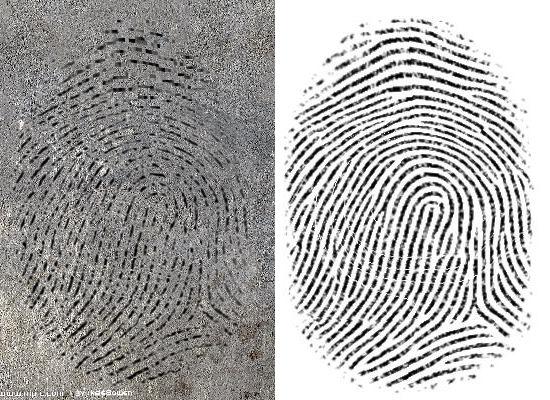

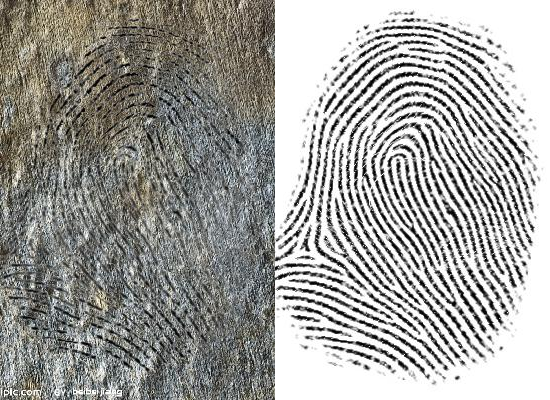

In [8]:
random_filenames = np.random.choice(filenames, 2)
for fname in random_filenames:
    img_input = cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.cvtColor(img_truth, cv2.COLOR_GRAY2BGR)
    imshow(np.concatenate([img_input, img_truth], axis=1))

In [9]:
import importlib

import data_loading as load
importlib.reload(load)

import data_preprocessing as prep

In [10]:
input_func_list = [prep.normalize_pixels]
truth_func_list = [prep.invert, prep.to_grayscale, prep.normalize_pixels]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)

In [25]:
train_ds = ds_factory.create_dataset(PATH_TO_INPUT, PATH_TO_TRUTH)
min_ds = ds_factory.create_dataset(PATH_TO_MIN_INPUT, PATH_TO_MIN_TRUTH)

Found 75600 files belonging to 1 classes.
Found 75600 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


In [18]:
input_batch, truth_batch = next(train_ds.as_numpy_iterator())
input_batch.shape, truth_batch.shape

((4, 400, 275, 3), (4, 400, 275, 1))

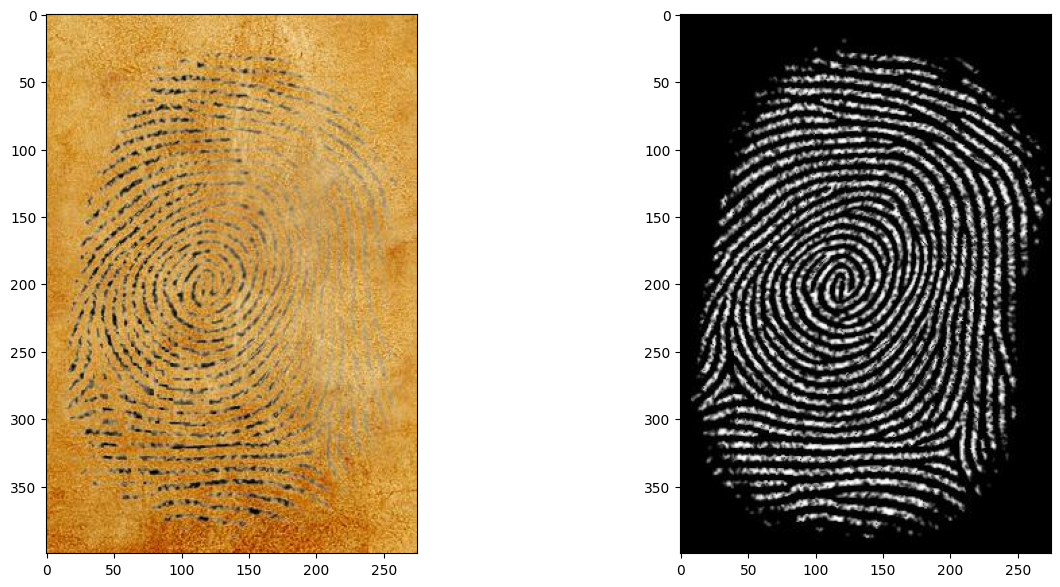

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(input_batch[3])
axs[1].imshow(truth_batch[3], cmap="gray", vmin=0, vmax=1)

In [23]:
from models import get_unet
unet_model = get_unet(3)
unet_model.compile(optimizer='adam', loss=['mse'])

In [24]:
history = unet_model.fit(min_ds, epochs=3)

Epoch 1/3


2024-01-21 16:55:51.236618: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56115200 exceeds 10% of free system memory.
2024-01-21 16:55:51.395247: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56320000 exceeds 10% of free system memory.
2024-01-21 16:55:51.438276: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84480000 exceeds 10% of free system memory.
2024-01-21 16:55:51.484301: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84480000 exceeds 10% of free system memory.
2024-01-21 16:55:51.650236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84480000 exceeds 10% of free system memory.


25/25 [==============================] - 67s 3s/step - loss: 0.1016
Epoch 2/3
25/25 [==============================] - 62s 2s/step - loss: 0.0830
Epoch 3/3
25/25 [==============================] - 74s 3s/step - loss: 0.0718


In [31]:
res = unet_model.predict(next(iter(train_ds))[0])

1/1 [==============================] - 1s 585ms/step


In [47]:
img = tf.keras.utils.img_to_array(res[0])
img = np.repeat(img, 3, axis=-1)
img = ((1 - img) * 255.0).astype(np.uint8)

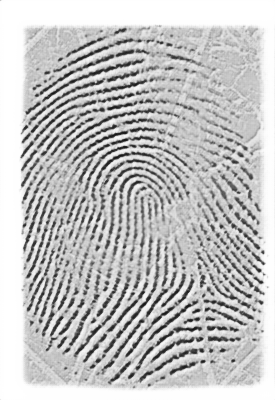

In [48]:
imshow(img)